# Practice 1: Modeling in vitro cell growth and death processes

To see short summary skip to 'Conclusions' section.

Tumor cells growing in-vitro in wells where they are allowed to grow freely in the presence of nutrients, present growth curves like the one in the figure.

<img src="img/im.png">

Several numerical examples are available in the Matlab files 'data/ejemplo1p1.mat' and 'data/ejemplo2p1.mat'
available. The variables that begin with "t" are the times of the measurements in
hours and the others are cellular index measured with an xCELLigence Real-Time Cell Analyzer, which is expected
that is approximately proportional to the number of cells.

# Task
It is requested to adjust a model of tumor growth with death and see if it is able to describe the results.

# Data we have:

Import modules we will use in this Notebook

In [45]:
import numpy as np
from scipy.io import loadmat
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

from scipy.optimize import curve_fit

In [46]:
mat = loadmat('data/ejemplo1.mat')
df_1 = pd.DataFrame()
for i in mat:
    if '__' not in i and 'readme' not in i:
        df_1[i] = pd.Series(mat[i][:,0])
df_1 = df_1.set_index('tH460_4000_B')
df_1.head()

,H460_2000_B,H460_4000_B
tH460_4000_B,,
0.0000,0.0000,0.0000
0.0033,-0.0005,0.0001
1.3417,0.0259,0.0608
1.8419,0.0176,0.0602
2.3422,0.0140,0.0601


In [47]:
mat = loadmat('data/ejemplo2.mat')
df_2 = pd.DataFrame()
for i in mat:
    if '__' not in i and 'readme' not in i:
        df_2[i] = pd.Series(mat[i][:, 0])
df_2 = df_2.set_index('t_2000')
df_2.head()

,SH460_2000
t_2000,
0.0000,0.0000
0.0092,0.0005
1.1411,-0.0554
1.6411,-0.0391
2.1414,-0.0578


Let's plot our data!

In [48]:
data = [df_1, df_2]

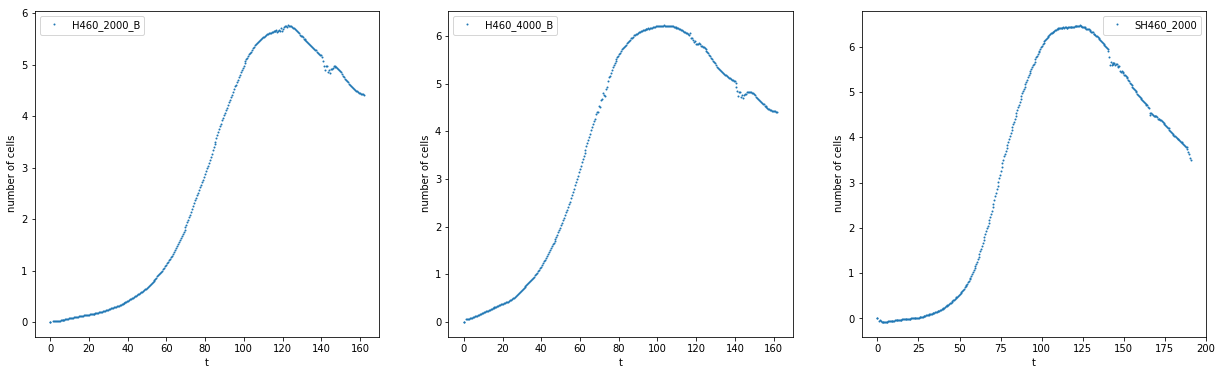

In [49]:
plt.rcParams["figure.figsize"] = (21,6) # set up plot sizes
def plot_collection(data):
    """
    Plots collection of data frames.
    """
    num_of_pictures_to_plot = 0 # each dataframe column is plotted in separate subplot
    for df in data:
        num_of_pictures_to_plot += df.shape[1]
    idx_curr_plot = 1
    for df in data:
        for column in df:
            plt.subplot(1, num_of_pictures_to_plot, idx_curr_plot)
            plt.plot(df[column], 'o', markersize=1,label=column)
            plt.xlabel('t')
            plt.ylabel('number of cells')
            plt.legend()
            idx_curr_plot += 1
plot_collection(data)

Pandas DataFrame type is perfect for tabular information analysis. But for plotting it would convenient to use simple lists:

In [50]:
d_time_1 = df_1.index.values
d_val_1_2000 = df_1['H460_2000_B'].values
d_val_1_4000 = df_1['H460_4000_B'].values
d_time_2 = df_2.index.values
d_val_2 = df_2['SH460_2000'].values

# Models we have:

## 1) Discrete model
$$N_{j+1} = 2 * N_j$$

For uniformity of further model's comparison we will switch to continious analog:
$$N(t) = a b^t$$
It is not adecuate transition to continous case probably(not at each new time moment $t$ we have new generation $j$; probably each generation $j$ lives some time span $[t_{j}, t_{j+1})$). However we will fit this function with parameters $a, b$.

In [51]:
def model_1(t, a, b):
    """
    Continuous analog of discrete model
    """
    return a * np.power(b, t)

We will use SciPy's curve_fit function - it returns tuple consisting from 2 parameters. The first of them is a list of optimal parameters for fittting into the data we have provided under our constraints.

In [52]:
def get_label(model, popt):
    """
    Return label for plotting.
    model: function
    popt: tuple of optimal parameters
    """
    args = str(inspect.signature(model)).split(',')
    for i in range(len(args)):
        args[i] = args[i].strip('0123456789()=')
    args = args[1:] # now 'args' contains names of parameters of 'model' func, except of the first one
    # time. we will use them for label during plotting
    tmp = ''
    for i in range(len(args)):
        tmp += args[i] + '=' + '{:.2f}'.format(popt[i]) + ' '
    model_label = model.__doc__ + tmp
    return model_label

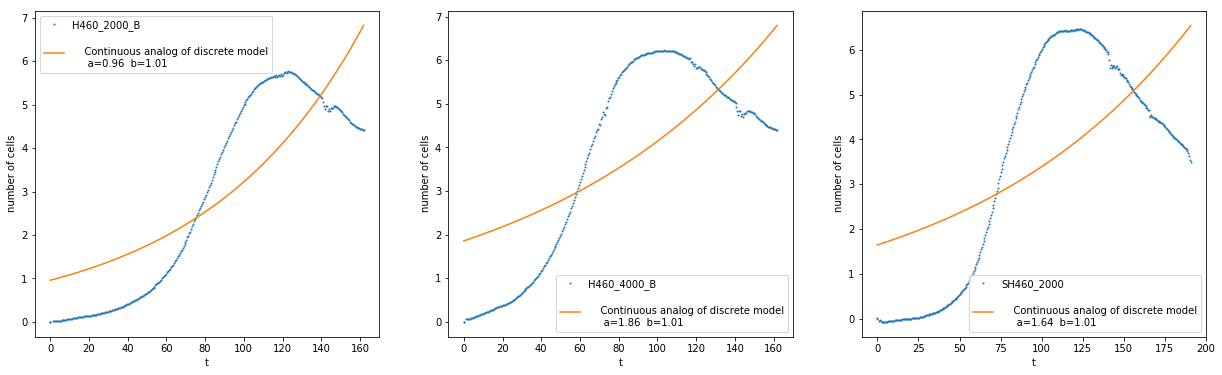

In [53]:
def fit_and_plot_collection(data, model, bounds):
    """
    Fits explicit 'model' function to each pd.Series in 'data' - collection of Data Frames and plots results
    in separate subplots.
    """
    popt_list = []
    num_of_pictures_to_plot = 0 # each dataframe column is plotted in separate subplot
    for df in data:
        num_of_pictures_to_plot += df.shape[1]
    idx_curr_plot = 1
    for df in data:
        for column in df:
            plt.subplot(1, num_of_pictures_to_plot, idx_curr_plot)
            # plot pure data
            plt.plot(df[column], 'o', markersize=1, label=column)
            # fit model to our data
            x = df[column].index.values
            y = df[column].values
            popt, pcov = curve_fit(model, x, y, bounds=bounds)
            popt_list.append(popt)
            # plot fitted graph
            plt.plot(x, model(x, *popt), label=get_label(model, popt))
            # make our plot beautiful
            plt.xlabel('t')
            plt.ylabel('number of cells')
            plt.legend()
            # auxiliary counter increasing
            idx_curr_plot += 1
    return popt_list
popt_list_1 = fit_and_plot_collection(data, model_1, bounds=(0, [3, 3]))
# print(popt_list_1)
# add error computing and parameters on labels of fitted function and visualization of difference of

In [54]:
def integrate_numerically(x, y):
    """
    Computes numerical integral of y = y(x)
    x - independent variable values
    y - dependent variable values
    """
    res = 0
    for i in range(0, len(x) - 1):
        res += (x[i+1] - x[i]) * y[i+1]
    return res

In [55]:
def compute_model_error(data, model, popt_list):
    """
    Computes model error on the whole dataset.
    data: collection of data Frames
    model: model we compute error for
    popt_list: list of optimal parameters for each data series
    """
    error = 0
    idx = 0
    for df in data:
        for column in df:
            tmp_abs_list = np.abs(model(df[column].index.values, *popt_list[idx]) - df[column]).values
            curr_error = integrate_numerically(df[column].index.values, tmp_abs_list)
            error += curr_error
            idx += 1
    return error

In [56]:
print(compute_model_error(data, model_1, popt_list_1))

725.3996323175852


## 2) Continuous model(no saturation)

$$\frac{dN(t)}{dt} = \lambda N(t) = \frac{N(t)}{\tau}$$
$$N(t_0) = N_0$$

$$N(t) = {N(t_0)}exp\Big(\frac{t - t_0}{\tau}\Big)$$

In [57]:
def model_2(t, n_init, tau):
    """Continuous model, no saturation"""
    t0 = 0
    return n_init * np.exp((t - t0) / tau)

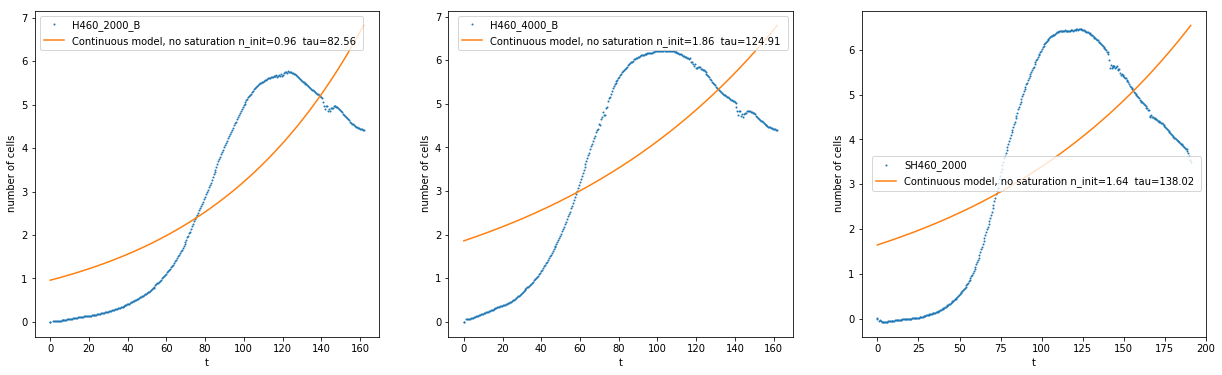

In [58]:
popt_list_2 = fit_and_plot_collection(data, model_2, bounds=(0, [100, 1000]))

To evaluate quality of each method fitting we numerically compute area between approximations and data we fit to.

In [59]:
print(compute_model_error(data, model_2, popt_list_2))

725.3998729444431


## 3) Logistic equation (model with saturation)

$$\frac{dN}{dt} = \frac{1}{\tau}N\Big(1 - \frac{N}{K}\Big)$$
where $\tau$ ~ Population doubling time, $K = $ Max. cell number
Solution of above equation is:
$$N(t) = \frac{K}{1 + (\frac{K}{N(0)} - 1)exp(-\frac{t}{\tau})}$$

In [60]:
K_MAX = None
def model_3(t, n_init, tau):
    """Logistic equation(with saturation)"""
    K = K_MAX
    return K / (1 + (K / n_init - 1) * np.exp(-t/tau))

We have to define $K$ for each case first (using our data):

In [61]:
K_1 = np.max(d_val_1_2000)
K_2 = np.max(d_val_1_4000)
K_3 = np.max(d_val_2)

In [62]:
K_MAX = K_1
popt_3_1, pcov_3_1 = curve_fit(model_3, d_time_1, d_val_1_2000, bounds=(0, [100, 1000]))
K_MAX = K_2
popt_3_2, pcov_3_2 = curve_fit(model_3, d_time_1, d_val_1_4000, bounds=(0, [100, 1000]))
K_MAX = K_3
popt_3_3, pcov_3_3 = curve_fit(model_3, d_time_2, d_val_2, bounds=(0, [100, 1000]))

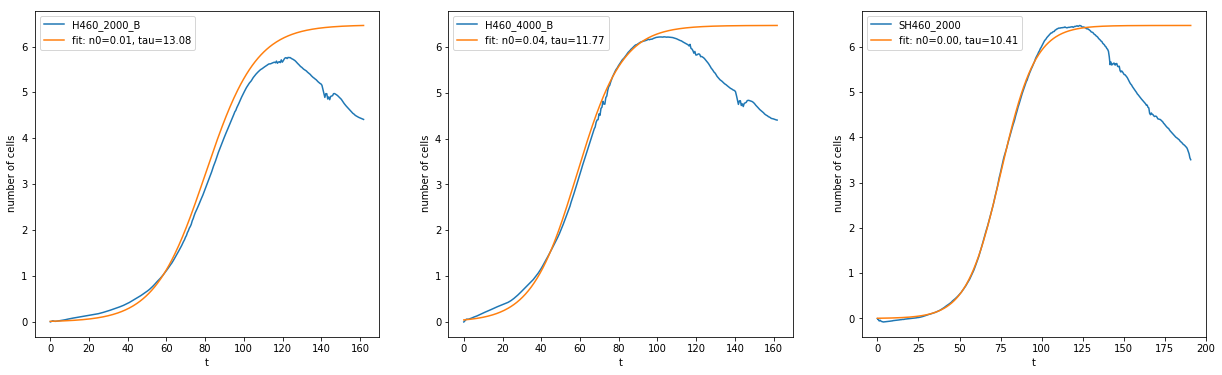

In [63]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_3(d_time_1, *popt_3_1), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_3_1[0], popt_3_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_3(d_time_1, *popt_3_2), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_3_2[0], popt_3_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_3(d_time_2, *popt_3_3), label='fit: n0={:.2f}, tau={:.2f}'.format(popt_3_3[0], popt_3_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [64]:
error_3_1 = np.abs(model_3(d_time_1, *popt_3_1) - d_val_1_2000)
error_3_2 = np.abs(model_3(d_time_1, *popt_3_2) - d_val_1_4000)
error_3_3 = np.abs(model_3(d_time_2, *popt_3_3) - d_val_2)

In [65]:
error_3 = integrate_numerically(d_time_1, error_3_1) + integrate_numerically(d_time_1, error_3_2) + integrate_numerically(d_time_2, error_3_3)
print(error_3)

249.6538262482398


## 4) Generalized logistics
(Does it satisfy our requirements?) - No, it doesn't.
* $f(t) \approx \frac{t}{\tau}$ only if $\nu > 0$
* $f(t) \rightarrow K, t \rightarrow \infty$ - is not true
$$f(t) = \frac{t}{\tau}\big(1 - {\Big(\frac{t}{K}\Big)}^\nu\big)$$

In [66]:
K_MAX = None
def model_4(t, tau, nu):
    K = K_MAX
    return (t / tau) * (1 - np.power((t / K), nu))

In [67]:
K_MAX = K_1
popt_4_1, pcov_4_1 = curve_fit(model_4, d_time_1, d_val_1_2000, bounds=(0, [100, 20]))
K_MAX = K_2
popt_4_2, pcov_4_2 = curve_fit(model_4, d_time_1, d_val_1_4000, bounds=(0, [100, 20]))
K_MAX = K_3
popt_4_3, pcov_4_3 = curve_fit(model_4, d_time_2, d_val_2, bounds=(0, [100, 20]))

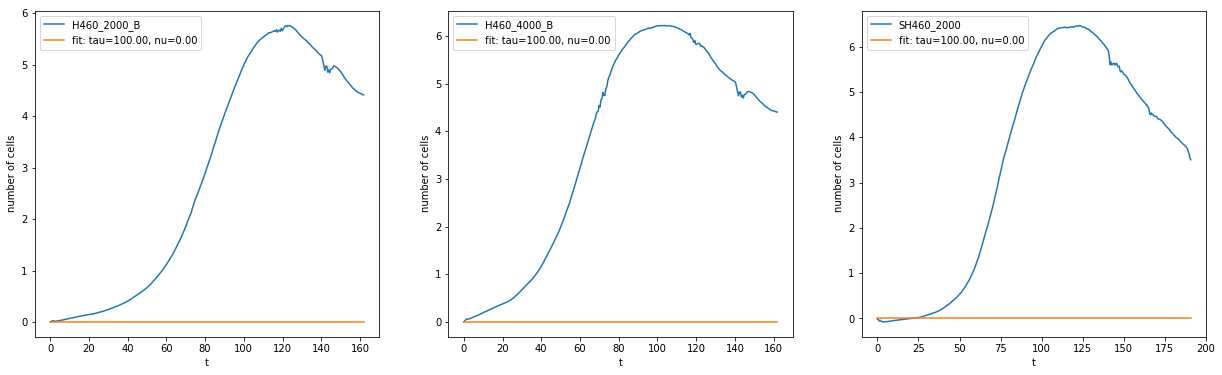

In [68]:
plt.rcParams["figure.figsize"] = (21,6)
plt.subplot(1, 3, 1)
plt.plot(d_time_1, d_val_1_2000, label='H460_2000_B');
plt.plot(d_time_1, model_4(d_time_1, *popt_4_1), label='fit: tau={:.2f}, nu={:.2f}'.format(popt_4_1[0], popt_4_1[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(d_time_1, d_val_1_4000, label='H460_4000_B');
plt.plot(d_time_1, model_4(d_time_1, *popt_4_2), label='fit: tau={:.2f}, nu={:.2f}'.format(popt_4_2[0], popt_4_2[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(d_time_2, d_val_2, label='SH460_2000')
plt.plot(d_time_2, model_4(d_time_2, *popt_4_3), label='fit: tau={:.2f}, nu={:.2f}'.format(popt_4_3[0], popt_4_3[1]))
plt.xlabel('t')
plt.ylabel('number of cells')
plt.legend();

In [69]:
error_4_1 = np.abs(model_4(d_time_1, *popt_4_1) - d_val_1_2000)
error_4_2 = np.abs(model_4(d_time_1, *popt_4_2) - d_val_1_4000)
error_4_3 = np.abs(model_4(d_time_2, *popt_4_3) - d_val_2)

In [70]:
error_4 = integrate_numerically(d_time_1, error_4_1) + integrate_numerically(d_time_1, error_4_2) + integrate_numerically(d_time_2, error_4_3)
print(error_4)

1725.5133896100494


## 5) Model with nutrients(resources) limitations
$$
\begin{equation*}
    \begin{cases}
    \frac{dN}{dt} = \frac{N}{\tau}\Big(1 - \frac{N}{K} \Big) - g(R)N
    \\
    \frac{dR}{dt} = -\lambda N
    \end{cases}
\end{equation*}
$$

where $R(t)$ - Resources level, $\lambda$ - resources consumption per cell

$$
\begin{equation*}
    g(R) = 
    \begin{cases}
        0 &\text{, $R \geq R_{*}$}
        \\
        g_0 &\text{, $R < R_{*}$}
    \end{cases}
\end{equation*}
$$

In [71]:
def model_5_system(x, t, tau=8.0, K=6.5, lamb=1.5):
    """
    System of equations corresponding to model with nutrients limitations.
    """
    def g(r):
        g_0 = 2.0
        r_threshold = 10.0
        if r >= r_threshold:
            return 0
        return g_0
    n = x[0]
    r = x[1]
    dndt = n / tau * (1 - n / K) - g(r) * n
    drdt = -lamb * n
    return [dndt, drdt]

In [72]:
x0 = [1e-2, 1000]
# t = np.linspace(0, 200, 1000)
t = data[0]['H460_2000_B'].index.values
x = odeint(model_5_system, x0, t)

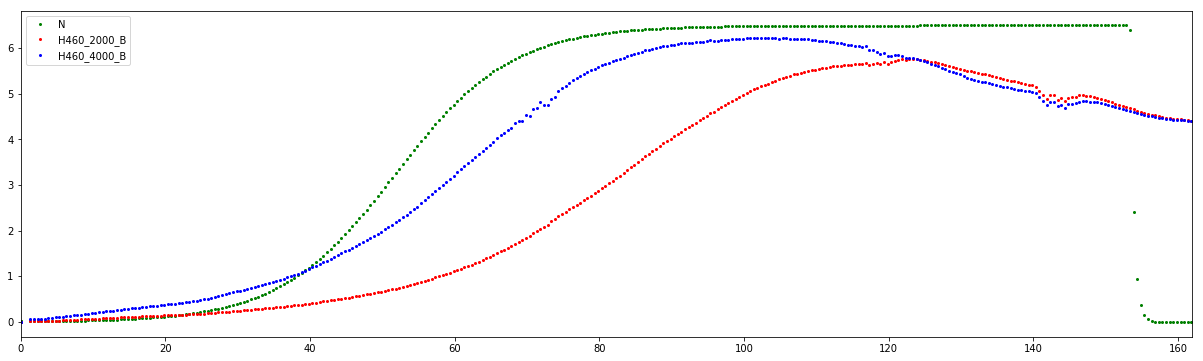

In [73]:
plt.plot(t, x[:, 0],'go', label='N', markersize=2)
# plt.plot(x[:, 1], label='R')
plt.plot(t, data[0]['H460_2000_B'], 'ro', markersize=2, label='H460_2000_B')
plt.plot(t, data[0]['H460_4000_B'], 'bo', markersize=2, label='H460_4000_B')
plt.xlim(0, 162)
plt.legend();

In [74]:
def compute_array_abs_diff(x, y_1, y_2):
    """
    Computes absolute value of difference of the two arrrays
    """
    if len(x) != len(y_1) or len(x) != len(y_2):
        raise Exception("Arrays should be of the same shape")
    acc = 0.0
    tmp_arr = np.abs(y_1 - y_2).values
    for i in range(1, len(x)):
        acc += (x[i] - x[i-1]) * tmp_arr[i]
    return acc

In [75]:
print(compute_array_abs_diff(t, x[:, 0], data[0]['H460_2000_B']))
print(compute_array_abs_diff(t, x[:, 0], data[0]['H460_4000_B']))

273.8507282913459
146.4321749008194


## 6) Power law model I
Surface driven growth model

$$
\frac{dV}{dt} = \alpha V^{\frac{2}{3}}
$$

$$
V(t) = {\big( V_0^{\frac{1}{3}} + \frac{1}{3}\alpha t\big)}^{3}
$$

In [76]:
def model_6(t, v_init, alpha):
    """
    Power law model I
    """
    return np.power(np.power(v_init, 1/3) + alpha * t / 3, 3)

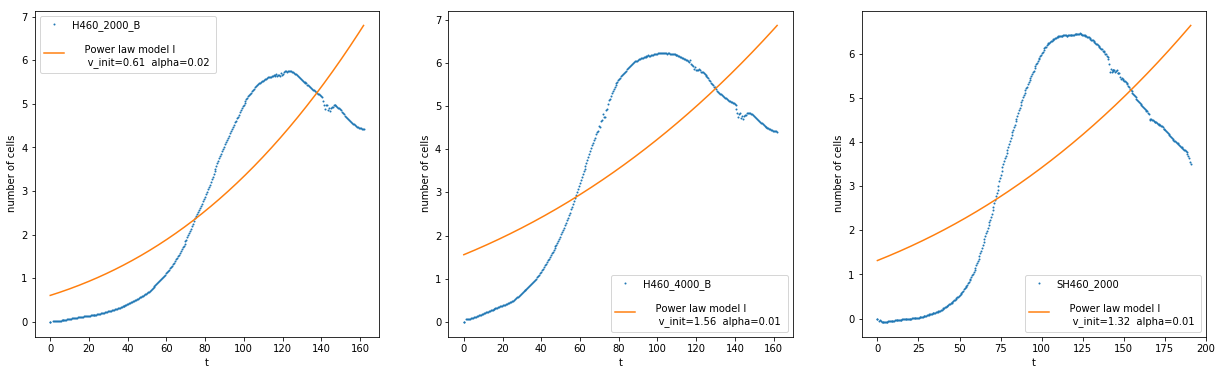

In [77]:
popt_list_6 = fit_and_plot_collection(data, model_6, bounds=(0, [10, 100]))

In [78]:
print(compute_model_error(data, model_6, popt_list_6))

678.2035172174667


## 7) Power law model II

$$
\frac{dV}{dt} = a V^{\frac{2}{3}} - b V
$$

$$
V(t) = \big[ \frac{a}{b} + (V_0^{\frac{1}{3}} - \frac{a}{b})e^{-\frac{2 b t}{3}} \big]^3
$$

In [79]:
def model_7(t, v_init, a, b):
    """
    Power law model II
    """
    return np.power(a/b + (np.power(v_init, 1/3) - a/b) * np.exp(-2 * b * t / 3), 3)

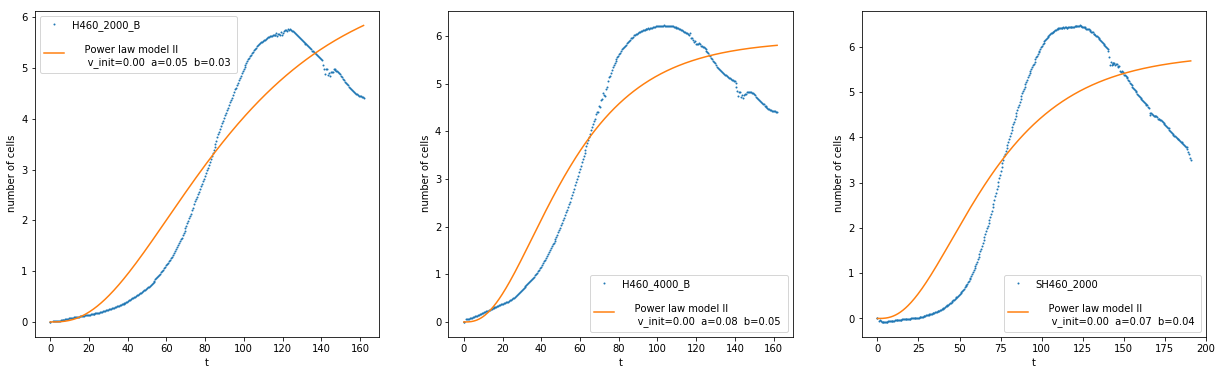

In [80]:
popt_list_7 = fit_and_plot_collection(data, model_7, bounds=(0, [10, 100, 100]))

In [81]:
print(compute_model_error(data, model_7, popt_list_7))

385.83874056133754


## 8) Dynamic carrying-capacity model

$$
\begin{equation*}
    \begin{cases}
    \frac{dV}{dt} = \frac{V}{\tau}\Big(1 - \frac{V}{K} \Big)
    \\
    \frac{dK}{dt} = b V^{\frac{2}{3}}
    \end{cases}
\end{equation*}
$$

where $\tau$ - proliferation time, $b$ - geometric factor surface-volume growth

In [82]:
def model_8_system(x, t, tau=1.0, b=2.0):
    """
    System of equations corresponding to dynamic carrying-capacity model.
    """
    v = x[0]
    k = x[1]
    dvdt = v / tau * (1 - v / k)
    dkdt = b * np.power(v, 2.0/3)
    return [dvdt, dkdt]

In [83]:
x0 = [1e-2, 7.0]
t = np.linspace(0, 200, 1000)
x = odeint(model_8_system, x0, t)

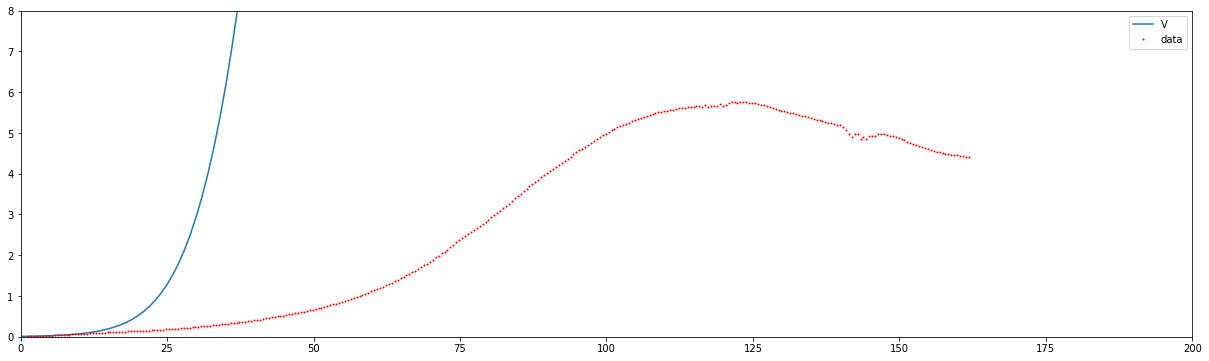

In [84]:
plt.plot(x[:, 0], label='V')
# plt.plot(x[:, 1], label='K')
plt.plot(data[0]['H460_2000_B'], 'ro', markersize=1, label='data')
plt.xlim(0, 200)
plt.ylim(0, 8)
plt.legend();

# P. S.
What if...

## 10) Polynomial 2nd degree


$$N(t) = a_0 + a_1 t + a_2 t^2$$

In [97]:
def model_10(t, a0, a1, a2):
    """
    Polynomial 2nd degree
    """
    return a0 + a1 * t + a2 * np.power(t, 2)

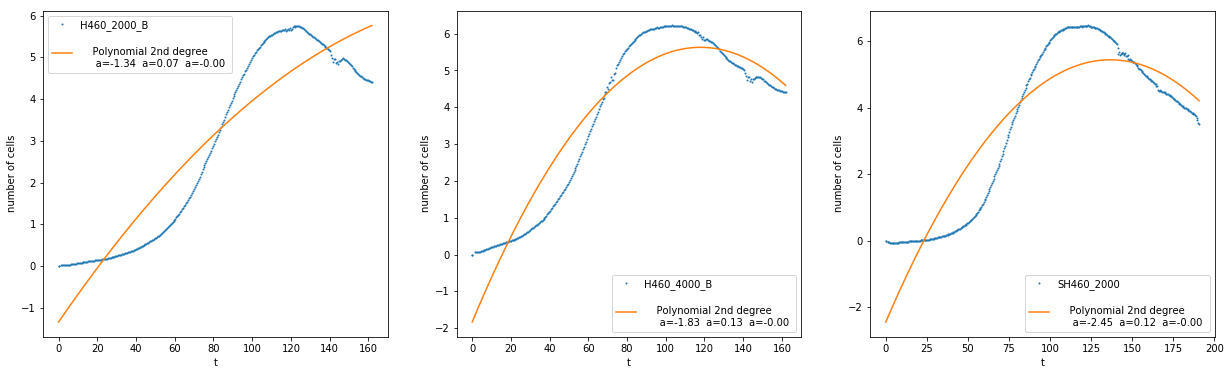

In [99]:
popt_list_10 = fit_and_plot_collection(data, model_10, bounds=(-100, [100, 100, 100]))

In [100]:
print(compute_model_error(data, model_10, popt_list_10))

381.6199162559508


## 11) Polynomial 5th degree

$$N(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5$$

In [101]:
def model_11(t, a0, a1, a2, a3, a4, a5):
    """
    Polynomial 5th degree
    """
    return a0 + a1 * t + a2 * np.power(t, 2) + a3 * np.power(t, 3) + a4 * np.power(t, 4) + a5 * np.power(t, 5)

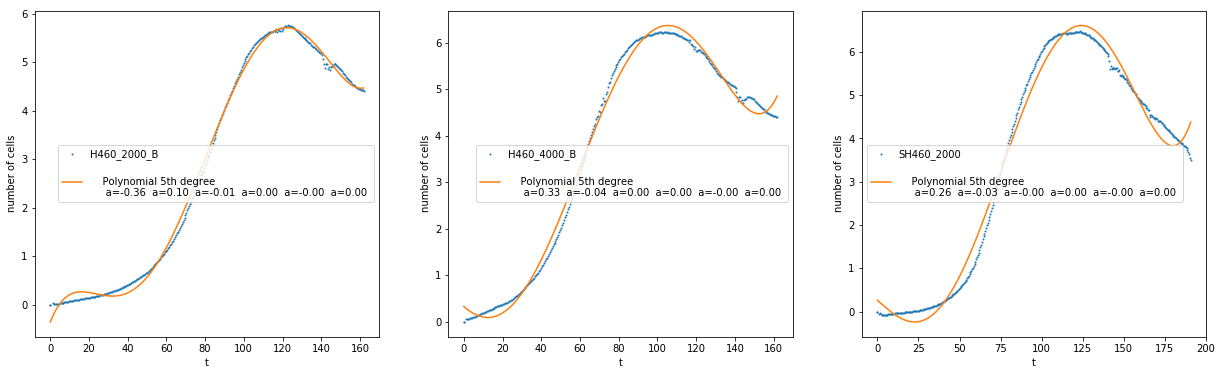

In [102]:
popt_list_11 = fit_and_plot_collection(data, model_11, bounds=(-100, [100]*6))

In [103]:
print(compute_model_error(data, model_11, popt_list_11))

82.1376635974888


# Conclusions

* Models 5 and 8 were fitted by hand(poorly). Fitting can be imporoved by grid search and then by GA or DL to minimize cost func
* According to received fitting errors list the best model that was explored is model #3 - *Logistic equation(model with saturation)*
* Curve fitting approach has found the same curves in models 1 and 2 - because it's the same functions classes
* None of the explored models fitting adequately describes decreasing of the number of the cells. Probably models